In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


# element = "P"
# element = "S"
element = "Si"

df_data_1_element_plot = pd.read_csv("data/df_data_1_" + element + "_plot.csv")
df_data_1_element_plot = df_data_1_element_plot[df_data_1_element_plot['转炉终点Mn'] != 0]


df_data_1_element_plot_future = df_data_1_element_plot[['转炉终点温度', '转炉终点C', '转炉终点Mn', '转炉终点S', '转炉终点P', '转炉终点Si',
                                                        '钢水净重', '氮化钒铁FeV55N11-A', '低铝硅铁', '钒氮合金(进口)', '钒铁(FeV50-B)', '硅铝钙',
                                                        '硅铝合金FeAl30Si25', '硅锰面（硅锰渣）', '硅铁(合格块)', '硅铁FeSi75-B', '石油焦增碳剂',
                                                        '锰硅合金FeMn64Si27(合格块)', '锰硅合金FeMn68Si18(合格块)', '碳化硅(55%)', '硅钙碳脱氧剂']]

standardScaler = StandardScaler()
standardScaler.fit(df_data_1_element_plot_future)
df_data_1_element_plot_future = pd.DataFrame(
    standardScaler.transform(df_data_1_element_plot_future))
df_data_1_element_plot_future.columns = df_data_1_element_plot_future.columns

df_data_1_element_plot_label = df_data_1_element_plot[element + '_Yield']

In [4]:
import hyperopt
from numpy.random import RandomState
import xgboost as xgb

params_space = {
    'max_depth': hyperopt.hp.randint('max_depth', 12),
    'learning_rate': hyperopt.hp.uniform('learning_rate', 1e-3, 5e-1),
    'n_estimators':hyperopt.hp.randint('n_estimators', 300)
}

def XGBRegressor_CV(params):
    from sklearn.model_selection import cross_val_score
    
    model = xgb.XGBRegressor(
        max_depth=int(params['max_depth']) + 1,
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        silent=1,
        objective='reg:linear',
        eval_metric='rmse',
        seed=42,
        nthread=-1,
        early_stopping_rounds=15
    )

    metric = cross_val_score(model, df_data_1_element_plot_future,df_data_1_element_plot_label, cv=5, scoring="neg_mean_squared_error")

    return np.mean(-metric)

trials = hyperopt.Trials()

best_element = hyperopt.fmin(
    XGBRegressor_CV,
    space=params_space,
    algo=hyperopt.tpe.suggest,
    max_evals=300,
    trials=trials,
    rstate=RandomState(42)
)

print("\n展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换")
print(best_element)

Element_CV_Model = xgb.XGBRegressor(
    max_depth= best_element["max_depth"] + 1,
    learning_rate=best_element["learning_rate"],
    n_estimators= best_element['n_estimators'],
    silent=1,
    objective='reg:linear',
    eval_metric='rmse',
    seed=42,
    nthread=-1,
    early_stopping_rounds=15
)

Element_CV_Model.fit( df_data_1_element_plot_future,df_data_1_element_plot_label)

Element_CV_Model.save_model('model/'+ element +'_CV_Model.model')

100%|██████████████████████████████████████████████| 300/300 [02:48<00:00,  1.85it/s, best loss: 0.0036243706330518267]

展示hyperopt获取的最佳结果，但是要注意的是我们对hyperopt最初的取值范围做过一次转换
{'n_estimators': 240, 'max_depth': 0, 'learning_rate': 0.42163481144317283}


MSE of predict on the Si model： 0.0005404285531317273
绝对误差 of predict on the Si model： 0.0177529132049767


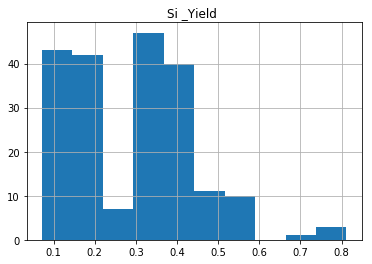

('Si', count    204.000000
 mean       0.293698
 std        0.147269
 min        0.072091
 25%        0.155606
 50%        0.319648
 75%        0.385631
 max        0.811592
 Name: Si_Yield, dtype: float64)

In [5]:
Element_CV_Model_new = xgb.Booster({'nthread': -1})  # init model
Element_CV_Model_new.load_model('model/'+ element +'_CV_Model.model')  # load data

dpredict = xgb.DMatrix(df_data_1_element_plot_future)
predict = Element_CV_Model_new.predict(dpredict)

from sklearn.metrics import mean_squared_error,mean_absolute_error
print("MSE of predict on the " +element + " model：", (mean_squared_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
print("绝对误差 of predict on the " +element + " model：", (mean_absolute_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
import matplotlib.pyplot as plt
%matplotlib inline
df_data_1_element_plot_label.hist()

plt.title(element +" _Yield ")
plt.show()
element,df_data_1_element_plot_label.describe()

## Si元素的预测结果较为理想

可能是由数据之外的一些关系造成的.

MSE of predict on the Si model： 0.0005404285531317273
绝对误差 of predict on the Si model： 0.0177529132049767


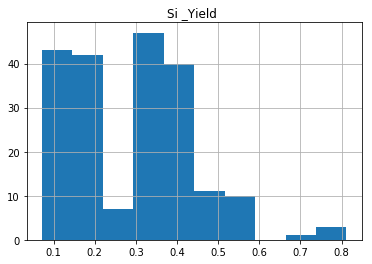

('Si', count    204.000000
 mean       0.293698
 std        0.147269
 min        0.072091
 25%        0.155606
 50%        0.319648
 75%        0.385631
 max        0.811592
 Name: Si_Yield, dtype: float64)

In [6]:
element = "Si"

Element_CV_Model_new = xgb.Booster({'nthread': -1})  # init model
Element_CV_Model_new.load_model('model/'+ element +'_CV_Model.model')  # load data

dpredict = xgb.DMatrix(df_data_1_element_plot_future)
predict = Element_CV_Model_new.predict(dpredict)

from sklearn.metrics import mean_squared_error,mean_absolute_error
print("MSE of predict on the " +element + " model：", (mean_squared_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
print("绝对误差 of predict on the " +element + " model：", (mean_absolute_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
import matplotlib.pyplot as plt
%matplotlib inline
df_data_1_element_plot_label.hist()

plt.title(element +" _Yield ")
plt.show()
element,df_data_1_element_plot_label.describe()

## P和S两种元素的预测结果并不理想

可能是由数据之外的一些关系造成的.

MSE of predict on the P model： 1.3700285209604723
绝对误差 of predict on the P model： 0.9554501695529706


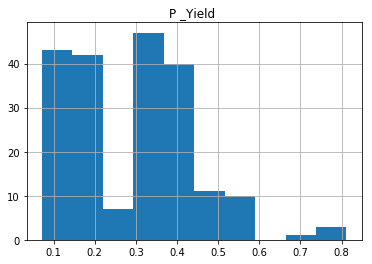

('P', count    204.000000
 mean       0.293698
 std        0.147269
 min        0.072091
 25%        0.155606
 50%        0.319648
 75%        0.385631
 max        0.811592
 Name: Si_Yield, dtype: float64)

In [7]:
element = "P"

Element_CV_Model_new = xgb.Booster({'nthread': -1})  # init model
Element_CV_Model_new.load_model('model/'+ element +'_CV_Model.model')  # load data

dpredict = xgb.DMatrix(df_data_1_element_plot_future)
predict = Element_CV_Model_new.predict(dpredict)

from sklearn.metrics import mean_squared_error,mean_absolute_error
print("MSE of predict on the " +element + " model：", (mean_squared_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
print("绝对误差 of predict on the " +element + " model：", (mean_absolute_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
import matplotlib.pyplot as plt
%matplotlib inline
df_data_1_element_plot_label.hist()

plt.title(element +" _Yield ")
plt.show()
element,df_data_1_element_plot_label.describe()

MSE of predict on the S model： 41.263943806358796
绝对误差 of predict on the S model： 5.185296118171743


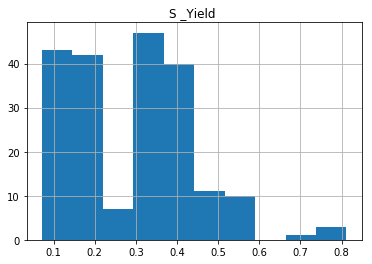

('S', count    204.000000
 mean       0.293698
 std        0.147269
 min        0.072091
 25%        0.155606
 50%        0.319648
 75%        0.385631
 max        0.811592
 Name: Si_Yield, dtype: float64)

In [8]:
element = "S"

Element_CV_Model_new = xgb.Booster({'nthread': -1})  # init model
Element_CV_Model_new.load_model('model/'+ element +'_CV_Model.model')  # load data

dpredict = xgb.DMatrix(df_data_1_element_plot_future)
predict = Element_CV_Model_new.predict(dpredict)

from sklearn.metrics import mean_squared_error,mean_absolute_error
print("MSE of predict on the " +element + " model：", (mean_squared_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
print("绝对误差 of predict on the " +element + " model：", (mean_absolute_error(y_true=df_data_1_element_plot_label,y_pred=predict)))
import matplotlib.pyplot as plt
%matplotlib inline
df_data_1_element_plot_label.hist()

plt.title(element +" _Yield ")
plt.show()
element,df_data_1_element_plot_label.describe()

In [9]:
def Train_model(model,df_future, df_label,  y="Mn_Yield", scoring="r2"):

    # 训练模型，估计模型参数
    model.fit(df_future, df_label)

    from sklearn.model_selection import cross_val_score
    scores_clf_svc_cv = cross_val_score(model, df_future, df_label, cv=5, scoring=scoring)

    print(np.mean(scores_clf_svc_cv), scores_clf_svc_cv)

    return model

In [11]:
element = "P"

df_data_1_element_plot = pd.read_csv("data/df_data_1_" + element + "_plot.csv")
df_data_1_element_plot = df_data_1_element_plot[df_data_1_element_plot['转炉终点Mn'] != 0]


df_data_1_element_plot_future = df_data_1_element_plot[['转炉终点温度', '转炉终点C', '转炉终点Mn', '转炉终点S', '转炉终点P', '转炉终点Si',
                                                        '钢水净重', '氮化钒铁FeV55N11-A', '低铝硅铁', '钒氮合金(进口)', '钒铁(FeV50-B)', '硅铝钙',
                                                        '硅铝合金FeAl30Si25', '硅锰面（硅锰渣）', '硅铁(合格块)', '硅铁FeSi75-B', '石油焦增碳剂',
                                                        '锰硅合金FeMn64Si27(合格块)', '锰硅合金FeMn68Si18(合格块)', '碳化硅(55%)', '硅钙碳脱氧剂']]

standardScaler = StandardScaler()
standardScaler.fit(df_data_1_element_plot_future)
df_data_1_element_plot_future_standardization = pd.DataFrame(
    standardScaler.transform(df_data_1_element_plot_future))
df_data_1_element_plot_future_standardization.columns = df_data_1_element_plot_future.columns

df_data_1_element_plot_label = df_data_1_element_plot[element + '_Yield']

In [12]:
from sklearn import linear_model
linearRegression = linear_model.LinearRegression()

linearRegression = Train_model(
    model=linearRegression,df_future=df_data_1_element_plot_future_standardization,df_label=df_data_1_element_plot_label, scoring='neg_mean_squared_error')
linearRegression.coef_, linearRegression.intercept_

-2.4042597145160114 [-1.82620695 -0.52302143 -1.89594331 -1.26259064 -6.51353625]


(array([ 9.30427062e-02, -1.99626780e-01,  6.86805157e-02, -1.81501438e-01,
        -9.08799538e-01, -1.41501232e-01,  8.02447355e-01,  3.24478884e-02,
        -7.79859485e-01,  6.83333877e-01,  3.00862781e-01, -1.55789774e-01,
        -1.17272678e-01, -1.27502054e-01,  7.77156117e-16, -5.02863744e-01,
        -1.72485978e-01, -2.25874249e-02,  6.74100774e-02,  2.92953805e-03,
        -5.67438363e-02]), 0.8143628134015767)

In [13]:
linearRegression = Train_model(
    model=linearRegression,df_future=df_data_1_element_plot_future_standardization,df_label=df_data_1_element_plot_label, scoring='r2')
linearRegression.coef_, linearRegression.intercept_

-0.7283028174118462 [ 0.39088152  0.55537691  0.12040542 -0.02475147 -4.68342648]


(array([ 9.30427062e-02, -1.99626780e-01,  6.86805157e-02, -1.81501438e-01,
        -9.08799538e-01, -1.41501232e-01,  8.02447355e-01,  3.24478884e-02,
        -7.79859485e-01,  6.83333877e-01,  3.00862781e-01, -1.55789774e-01,
        -1.17272678e-01, -1.27502054e-01,  7.77156117e-16, -5.02863744e-01,
        -1.72485978e-01, -2.25874249e-02,  6.74100774e-02,  2.92953805e-03,
        -5.67438363e-02]), 0.8143628134015767)